# Dynamics via acceleration maps

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import analysis

from importlib import reload

L_box = 50
mu_factor = 6  # conversion to microns
min_factor = 8  # conversion to minutes

In [ ]:
import yaml


def apply_time_filter(df, dt):
    """
    dt : float, in min
    """
    df["ts"] = df["time[hr]"] * 60 // dt
    return df.drop_duplicates(subset=["ts", "rid"], keep="first").reset_index(drop=True)


def _get_mp_type(yfile):
    with open(yfile) as f:
        return yaml.safe_load(f)["substrate"]["kind"]


def _make_title(df):
    tbl = {
        "gamma": r"$\gamma$",
        "R_eq": r"$R_{eq}$",
        "mag_std": r"$\sigma_{MVG}$",
        "add_rate": r"$\tau_{MVG}$",
        "gid": "ID",
    }
    d = dict(df.iloc[0][3:8])
    title = ""
    for key, val in d.items():
        title += tbl[key] + " = " + f"{val}" + "\n"
    return title


def linear_init_pts(xmin, xmax, vmin, vmax, n_pts, s=1, basin_only=False):
    def _around_basin():
        d = 10
        x1 = np.linspace(xmin - d, xmin + d, n_pts)
        x2 = np.linspace(xmax - d, xmax + d, n_pts)
        x = np.append(x1, x2)
        y = s * (vmax - vmin) / (xmax - xmin) * (x - xmin) + vmin
        return np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

    if basin_only:
        return _around_basin()

    x = np.linspace(xmin, xmax, n_pts)
    y = s * (vmax - vmin) / (xmax - xmin) * (x - xmin) + vmin
    return np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])


def F_init_pts(F, bounds):
    y_indx, x_indx = np.where(~np.isnan(F))
    xmin, xmax, vmin, vmax, nbins = bounds

    yy = vmin + y_indx * (vmax - vmin) / nbins
    xx = xmin + x_indx * (xmax - xmin) / nbins
    return np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])


def init_lattice(F, bounds):
    xmin, xmax, vmin, vmax, nbins = bounds
    X, Y = np.meshgrid(
        np.linspace(xmin, xmax, nbins),
        np.linspace(vmin, vmax, nbins),
    )
    non_nans = np.argwhere(~np.isnan(F))
    x, y = X[0][non_nans[:, 1]], Y[:, 0][non_nans[:, 0]]
    return X, Y, np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])


def get_xv_traj_for_gid(gid):
    df_gid_singleRunLong = pd.read_pickle(
        f"../_server/sim_data/corners_only_2/single_run_long/pkls/fulltake_gid{gid}.pkl"
    )
    df_gid_singleRunLong.x *= mu_factor
    df_gid_singleRunLong.y *= mu_factor

    singleRun_xva = analysis.calc_v_a_from_position(
        df_gid_singleRunLong.x, df_gid_singleRunLong["time[hr]"]
    )
    return singleRun_xva[["x", "v"]].to_numpy()

#### Load grid by grid
- Load `fulltake_gid*.pkl`, which is all of the runs for a config

In [ ]:
from glob import glob

files = glob("../_server/sim_data/corners_only/pkls/fulltake_gid*.pkl")

data = []

for file in files:
    df = pd.read_pickle(file)
    df.x *= mu_factor
    df.y *= mu_factor
    data.append(df)

print(f"Loaded {len(data)} configurations.")
[
    print(
        f"\t - Grid {df.gid.iloc[0]}: {len(df)} total data points | {len(df.rid.unique())} runs | {len(df[df.rid==0])} data points / run"
    )
    for df in data
]
display(data[0])

#### Calculate $\{v, a\}$ and bin $\{x, v, a\}$

In [ ]:
import os

gid = 15
save_path = (
    f"../_server/sim_data/corners_only/resolve_streamplots/12_min_interval/grid {gid}/"
)
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
gid_to_indx = dict((data[k].iloc[0].gid.astype(int), k) for k in range(len(data)))


In [ ]:
df_gid = data[gid_to_indx[gid]]
df_gid = apply_time_filter(df_gid, dt=12)

# compute speed and acc for each run
grid_x_v_a = []
for rid, df_rid in df_gid.groupby("rid"):
    x_v_a = analysis.calc_v_a_from_position(df_rid.x, df_rid["time[hr]"])
    x_v_a[df_gid.iloc[0][5:].index] = df_gid.iloc[0][5:]
    x_v_a["rid"] = int(rid)
    grid_x_v_a.append(x_v_a)

grid_x_v_a = pd.concat(grid_x_v_a)

# with a 112mu mp, this gives bins of dim 3.5mu x 3.5mu
nbins = 32
analysis.get_bin_indices(grid_x_v_a, nbins)
grid_x_v_a

1. Stream lines for every possible lattice site with `broken_streamlines` == `False`

In [ ]:
reload(analysis)

dt = np.mean(np.diff(df_gid["time[hr]"]))  # hr

F, F_std, sigma = analysis.calc_F_sigma(grid_x_v_a, dt, nbins, min_pts=5)

bounds = grid_x_v_a.agg(["min", "max"])
xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]

plot_title = _make_title(grid_x_v_a)
mp_type = _get_mp_type(f"../configs/IM/grid_id{gid}/simbox.yaml")
plot_title += f"substrate = {mp_type}"
bounds = (xmin, xmax, vmin, vmax, nbins)
title = {"title": plot_title, "size": 20}

X, Y, init_pts = init_lattice(F, bounds)

fig = analysis.F_streamplot(
    F,
    bounds,
    stream_init_pts=init_pts,
    title=title,
    interp="bilinear",
    streamplot_kwargs={
        "integration_direction": "forward",
        "color": "black",
        "broken_streamlines": False,
        "density": 1,
        "linewidth": 0.5,
    },
    # save_path=save_path + "full_lattice.png",
)
plt.show()


2. Color each lattice site depending on where it ends

In [ ]:
colors = []

for xx, yy in init_pts:
    fig, ax = plt.subplots(1, 1)
    try:
        stream = ax.streamplot(
            X,
            Y,
            Y,
            F,
            linewidth=0.5,
            start_points=[[xx, yy]],
            integration_direction="forward",
            color="black",
            broken_streamlines=False,
            density=1,
        )
        streamlines = np.array(stream.lines.get_segments())
        plt.close(fig)

        if len(streamlines) == 0:
            colors.append("gainsboro")
            continue

        end_pt = streamlines[-1][-1]
        if end_pt[0] < 133:
            colors.append("red")
        elif end_pt[0] > 167:
            colors.append("blue")
        else:
            colors.append("orange")

    except ValueError:
        colors.append("gainsboro")
        plt.close(fig)
        continue


In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color="red", label="Left")
blue_patch = mpatches.Patch(color="blue", label="Right")
orange_patch = mpatches.Patch(color="orange", label="Middle")

legend = [red_patch, blue_patch, orange_patch]

plt.figure(figsize=(3, 3), dpi=300)
plt.vlines(
    x=133, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)
plt.vlines(
    x=167, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)


plt.legend(handles=legend, bbox_to_anchor=(1.01, 1))
plt.scatter(init_pts[:, 0], init_pts[:, 1], color=colors, s=5)
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
plt.savefig(save_path + "lattice_colors.png")
plt.close()


3. View stream line bunches per each category of end point behavior

In [ ]:
red_indx = np.where(np.array(colors) == "red")[0]
blue_indx = np.where(np.array(colors) == "blue")[0]
orange_indx = np.where(np.array(colors) == "orange")[0]


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
stream_colors = {"red": "lightcoral", "blue": "lightsteelblue", "orange": "wheat"}

for indx in [red_indx, blue_indx, orange_indx]:
    if len(indx) == 0:
        continue

    starting_pts = init_pts[indx]
    c = colors[indx[0]]
    stream_c = stream_colors[c]

    for xx, yy in starting_pts:
        stream = ax.streamplot(
            X,
            Y,
            Y,
            F,
            linewidth=1,
            start_points=[[xx, yy]],
            integration_direction="forward",
            color=stream_c,
            broken_streamlines=False,
            density=1,
        )
        streamlines = np.array(stream.lines.get_segments())

        if len(streamlines) == 0:
            continue

        start_pt = streamlines[0][0]
        end_pt = streamlines[-1][-1]
        ax.scatter(*end_pt, s=50, color=c, marker="*", zorder=5, label="end")
        ax.set_xlim(bounds[0:2])
        ax.set_ylim(bounds[2:4])
        ax.set_xlabel(r"$x$ ($\mu$m)")
        ax.set_ylabel(r"$v$ ($\mu$m/hr)")
        # ax.legend(bbox_to_anchor=(1.7, 1))
plt.savefig(save_path + f"lattice_segments.png")
plt.close()
# plt.show()


# Debugging rectangular phase space

In [1]:
def bin(d, dmin, dmax, nbins):
    d = np.array(d)
    width = (dmax - dmin) / nbins
    bin_indx = np.floor((d - dmin) / width).astype("int")
    return np.where(bin_indx == nbins, nbins - 1, bin_indx)


def _title(df):
    tbl = {
        "gamma": r"$\gamma$",
        "R_eq": r"$R_{eq}$",
        "mag_std": r"$\sigma_{MVG}$",
        "add_rate": r"$\tau_{MVG}$",
        "gid": "ID",
    }
    d = dict(df.iloc[0])
    title = ""
    for key, _ in tbl.items():
        title += tbl[key] + " = " + f"{d[key]}" + "\n"
    return title


In [2]:
colors = [
    "salmon",
    "lightgreen",
    "wheat",
    "cornflowerblue",
    "plum",
    "",
    "darkgreen",
    "red",
]
chunk = 3
start, end = int(chunk * 16), int((1 + chunk) * 16)
start, end = 0, 17
print(start, end)

0 17


Grid ID = 80
Grid ID = 81
Grid ID = 82
Grid ID = 83
Grid ID = 84
Grid ID = 85
Grid ID = 86
Grid ID = 87
Grid ID = 88
Grid ID = 89
Grid ID = 90
Grid ID = 91
Grid ID = 92
Grid ID = 93
Grid ID = 94
Grid ID = 95


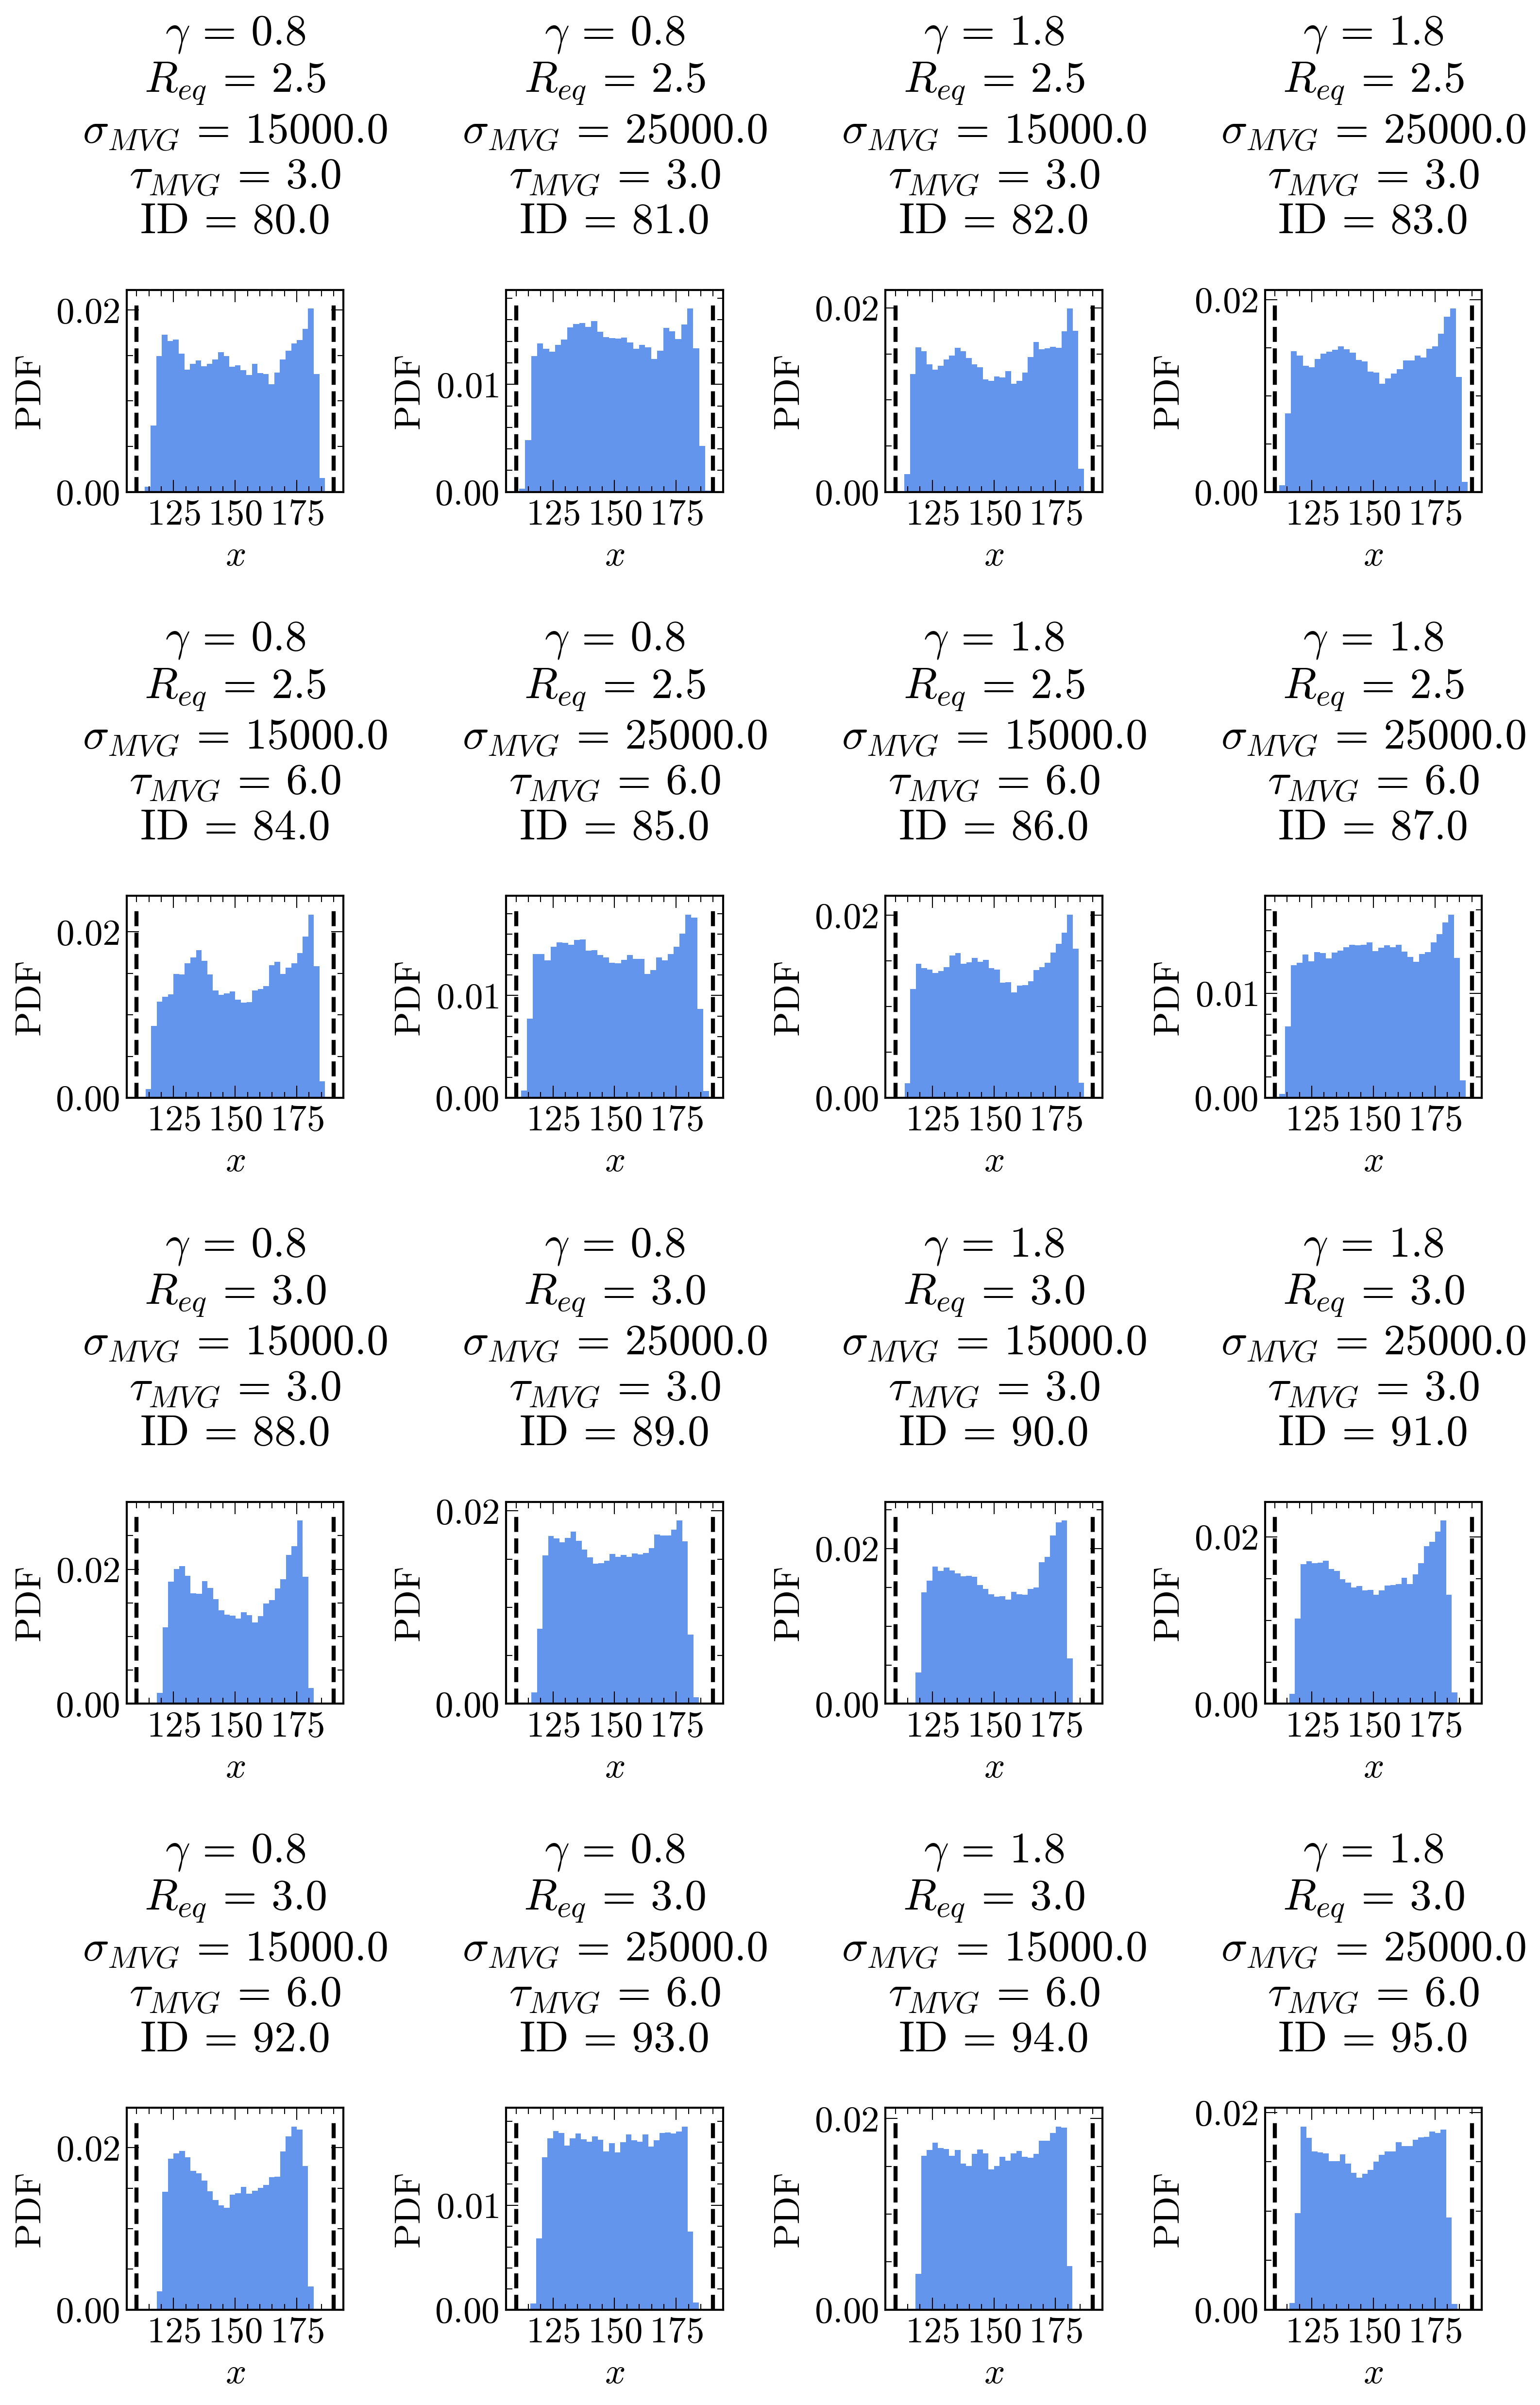

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


root = "debugging_asymmetry"
_format = "parquet"
# files = np.asarray(glob(f"../_server/sim_data/{root}/fulltake_gid*.{_format}"))

files = np.asarray(glob(f"../../../../Desktop/fulltake_gid*.{_format}"))

gids = np.asarray([int(f.split("gid")[-1].split(".")[0]) for f in files])
fig, axs = plt.subplots(4, 4, figsize=(12, 18), dpi=300)

for k, f in enumerate(files[np.argsort(gids)][start:end]):
    if _format == "pkl":
        df_gid = pd.read_pickle(f)
    else:
        df_gid = pd.read_parquet(f)

    gid = df_gid.iloc[0].gid.astype(int)
    print(f"Grid ID = {gid}")
    df_gid.x *= 6
    df_gid.y *= 6
    nbins = 32

    i, j = k // 4, k % 4
    axs[i, j].set_title(_title(df_gid))
    axs[i, j].hist(df_gid.x, bins=32, density=True, color=colors[chunk])
    axs[i, j].set_xlabel(r"$x$")
    axs[i, j].set_ylabel("PDF")
    axs[i, j].vlines(
        [110, 190], 0, axs[i, j].get_ylim()[1], color="black", linestyle="dashed"
    )

plt.subplots_adjust(wspace=0.75, hspace=2)
plt.show()

Grid ID = 80
Grid ID = 81
Grid ID = 82
Grid ID = 83
Grid ID = 84
Grid ID = 85
Grid ID = 86
Grid ID = 87
Grid ID = 88
Grid ID = 89
Grid ID = 90
Grid ID = 91
Grid ID = 92
Grid ID = 93
Grid ID = 94
Grid ID = 95


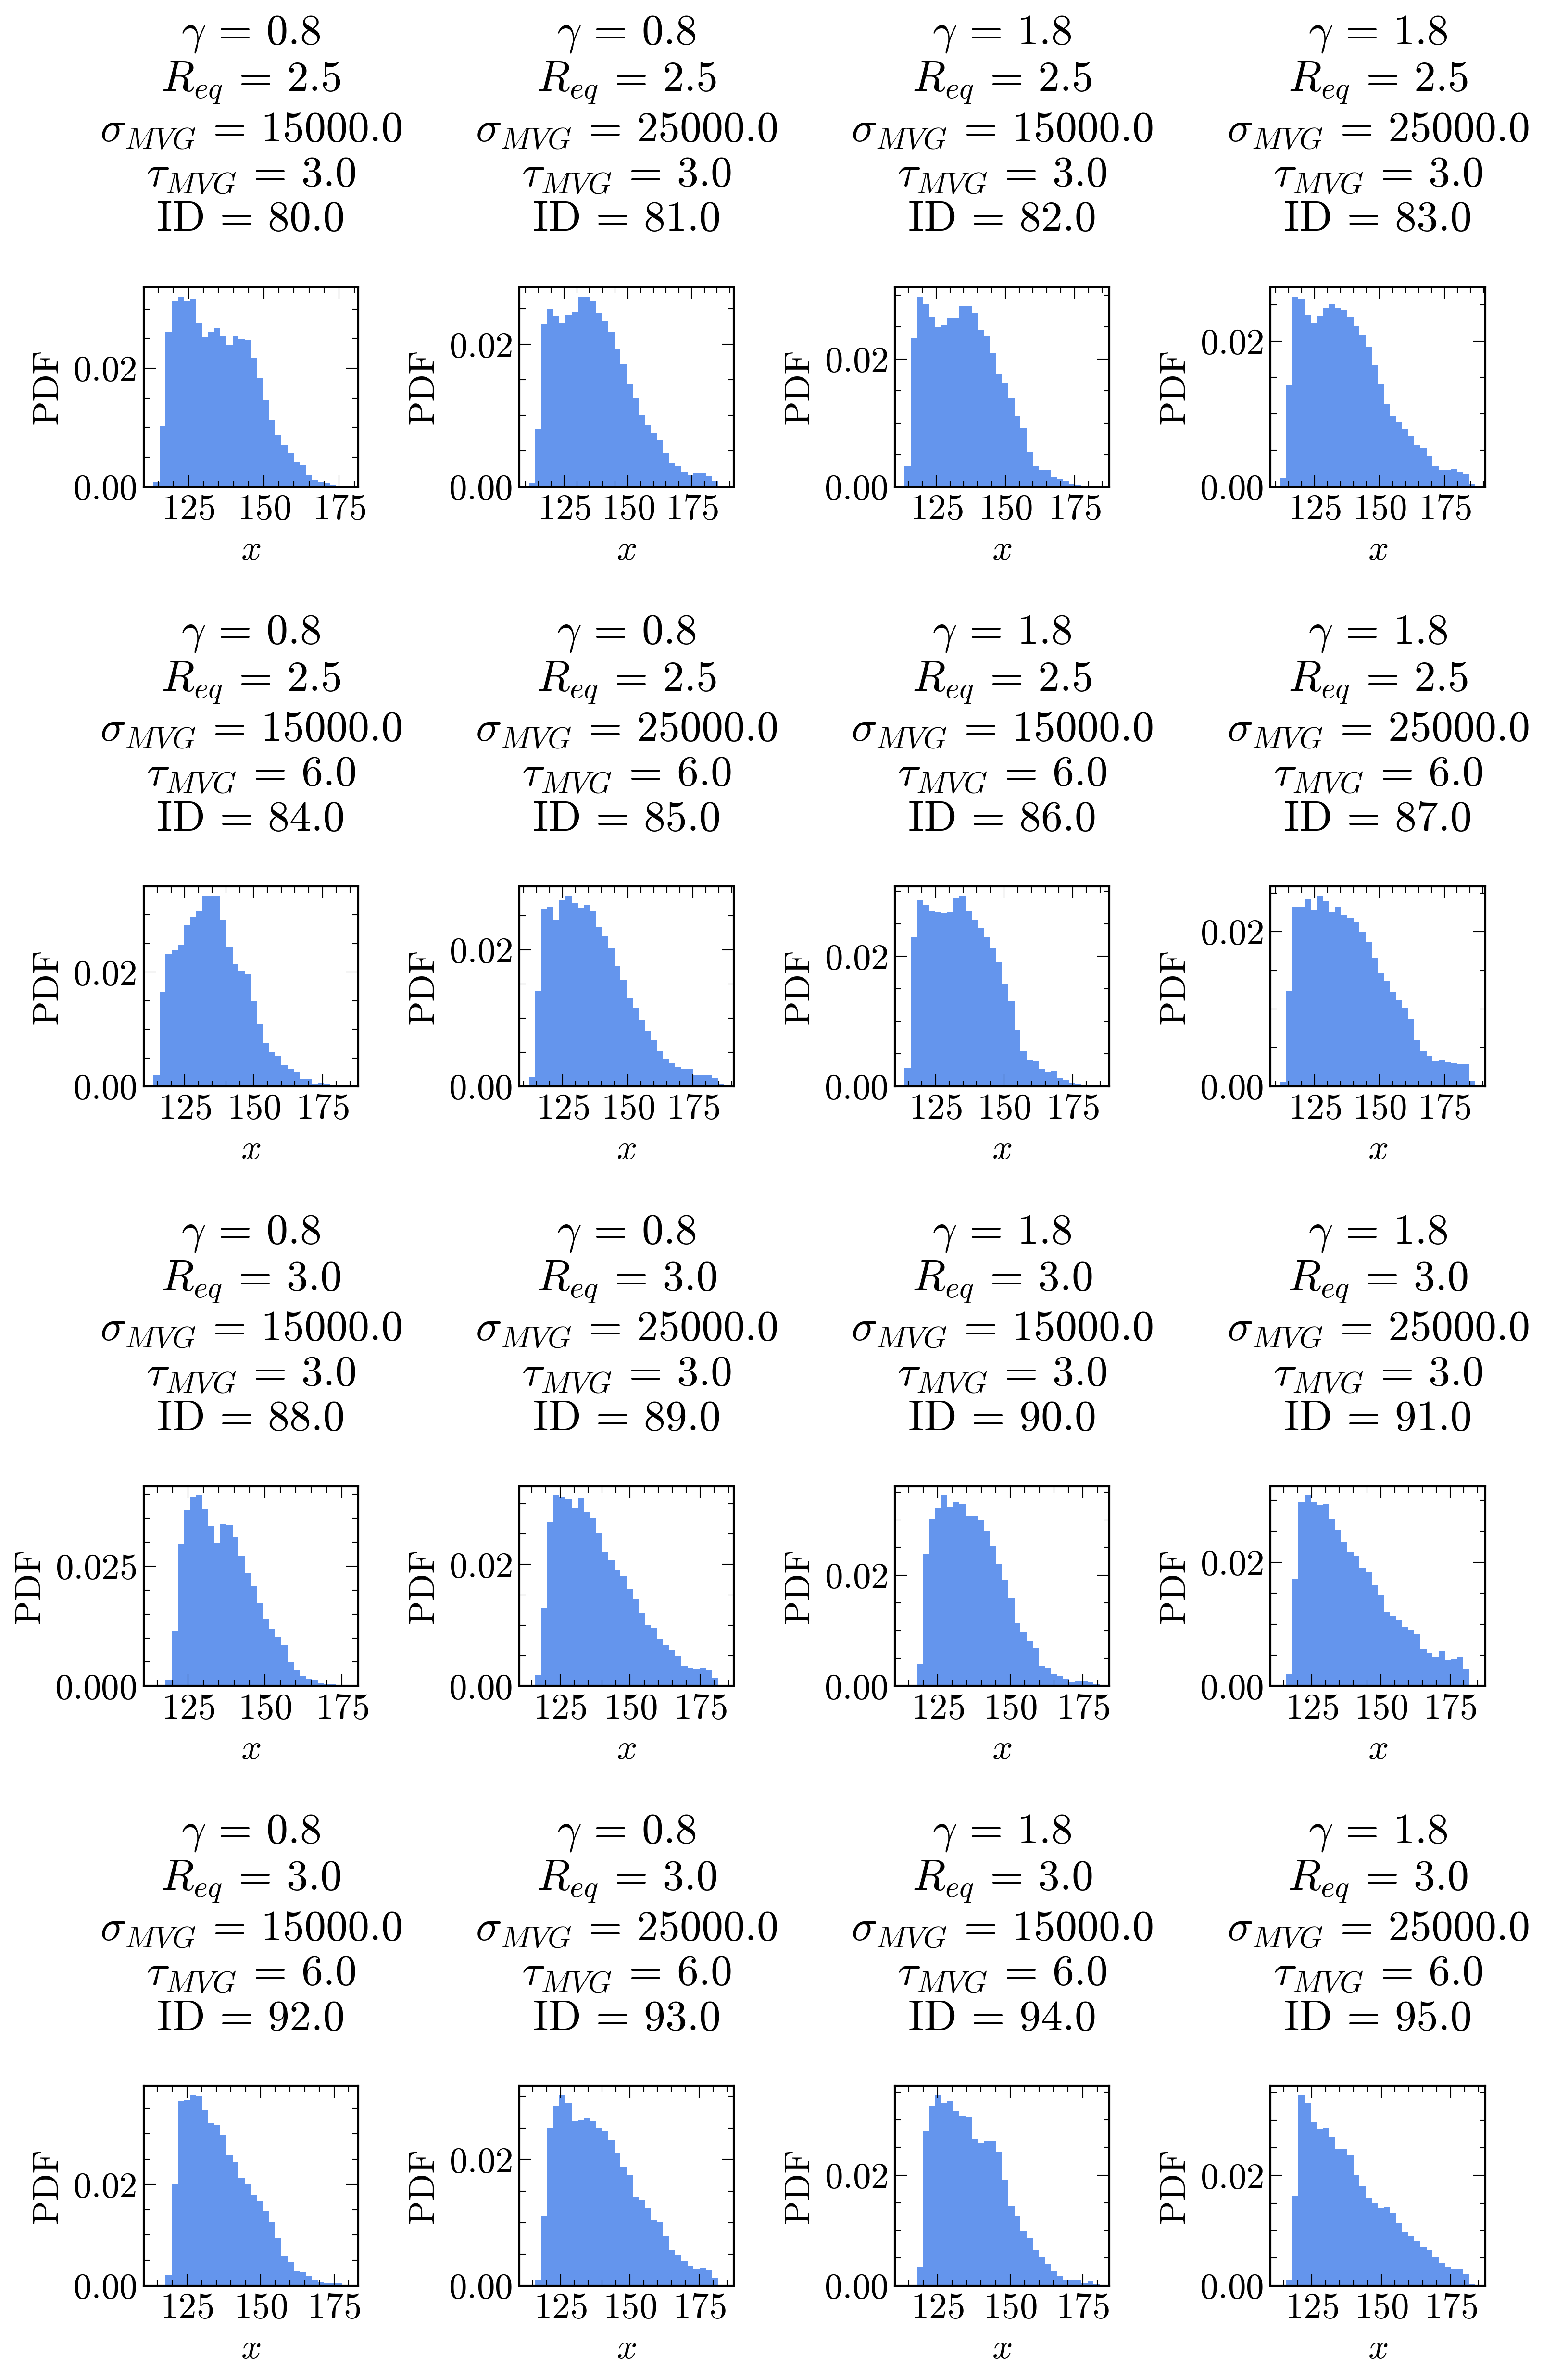

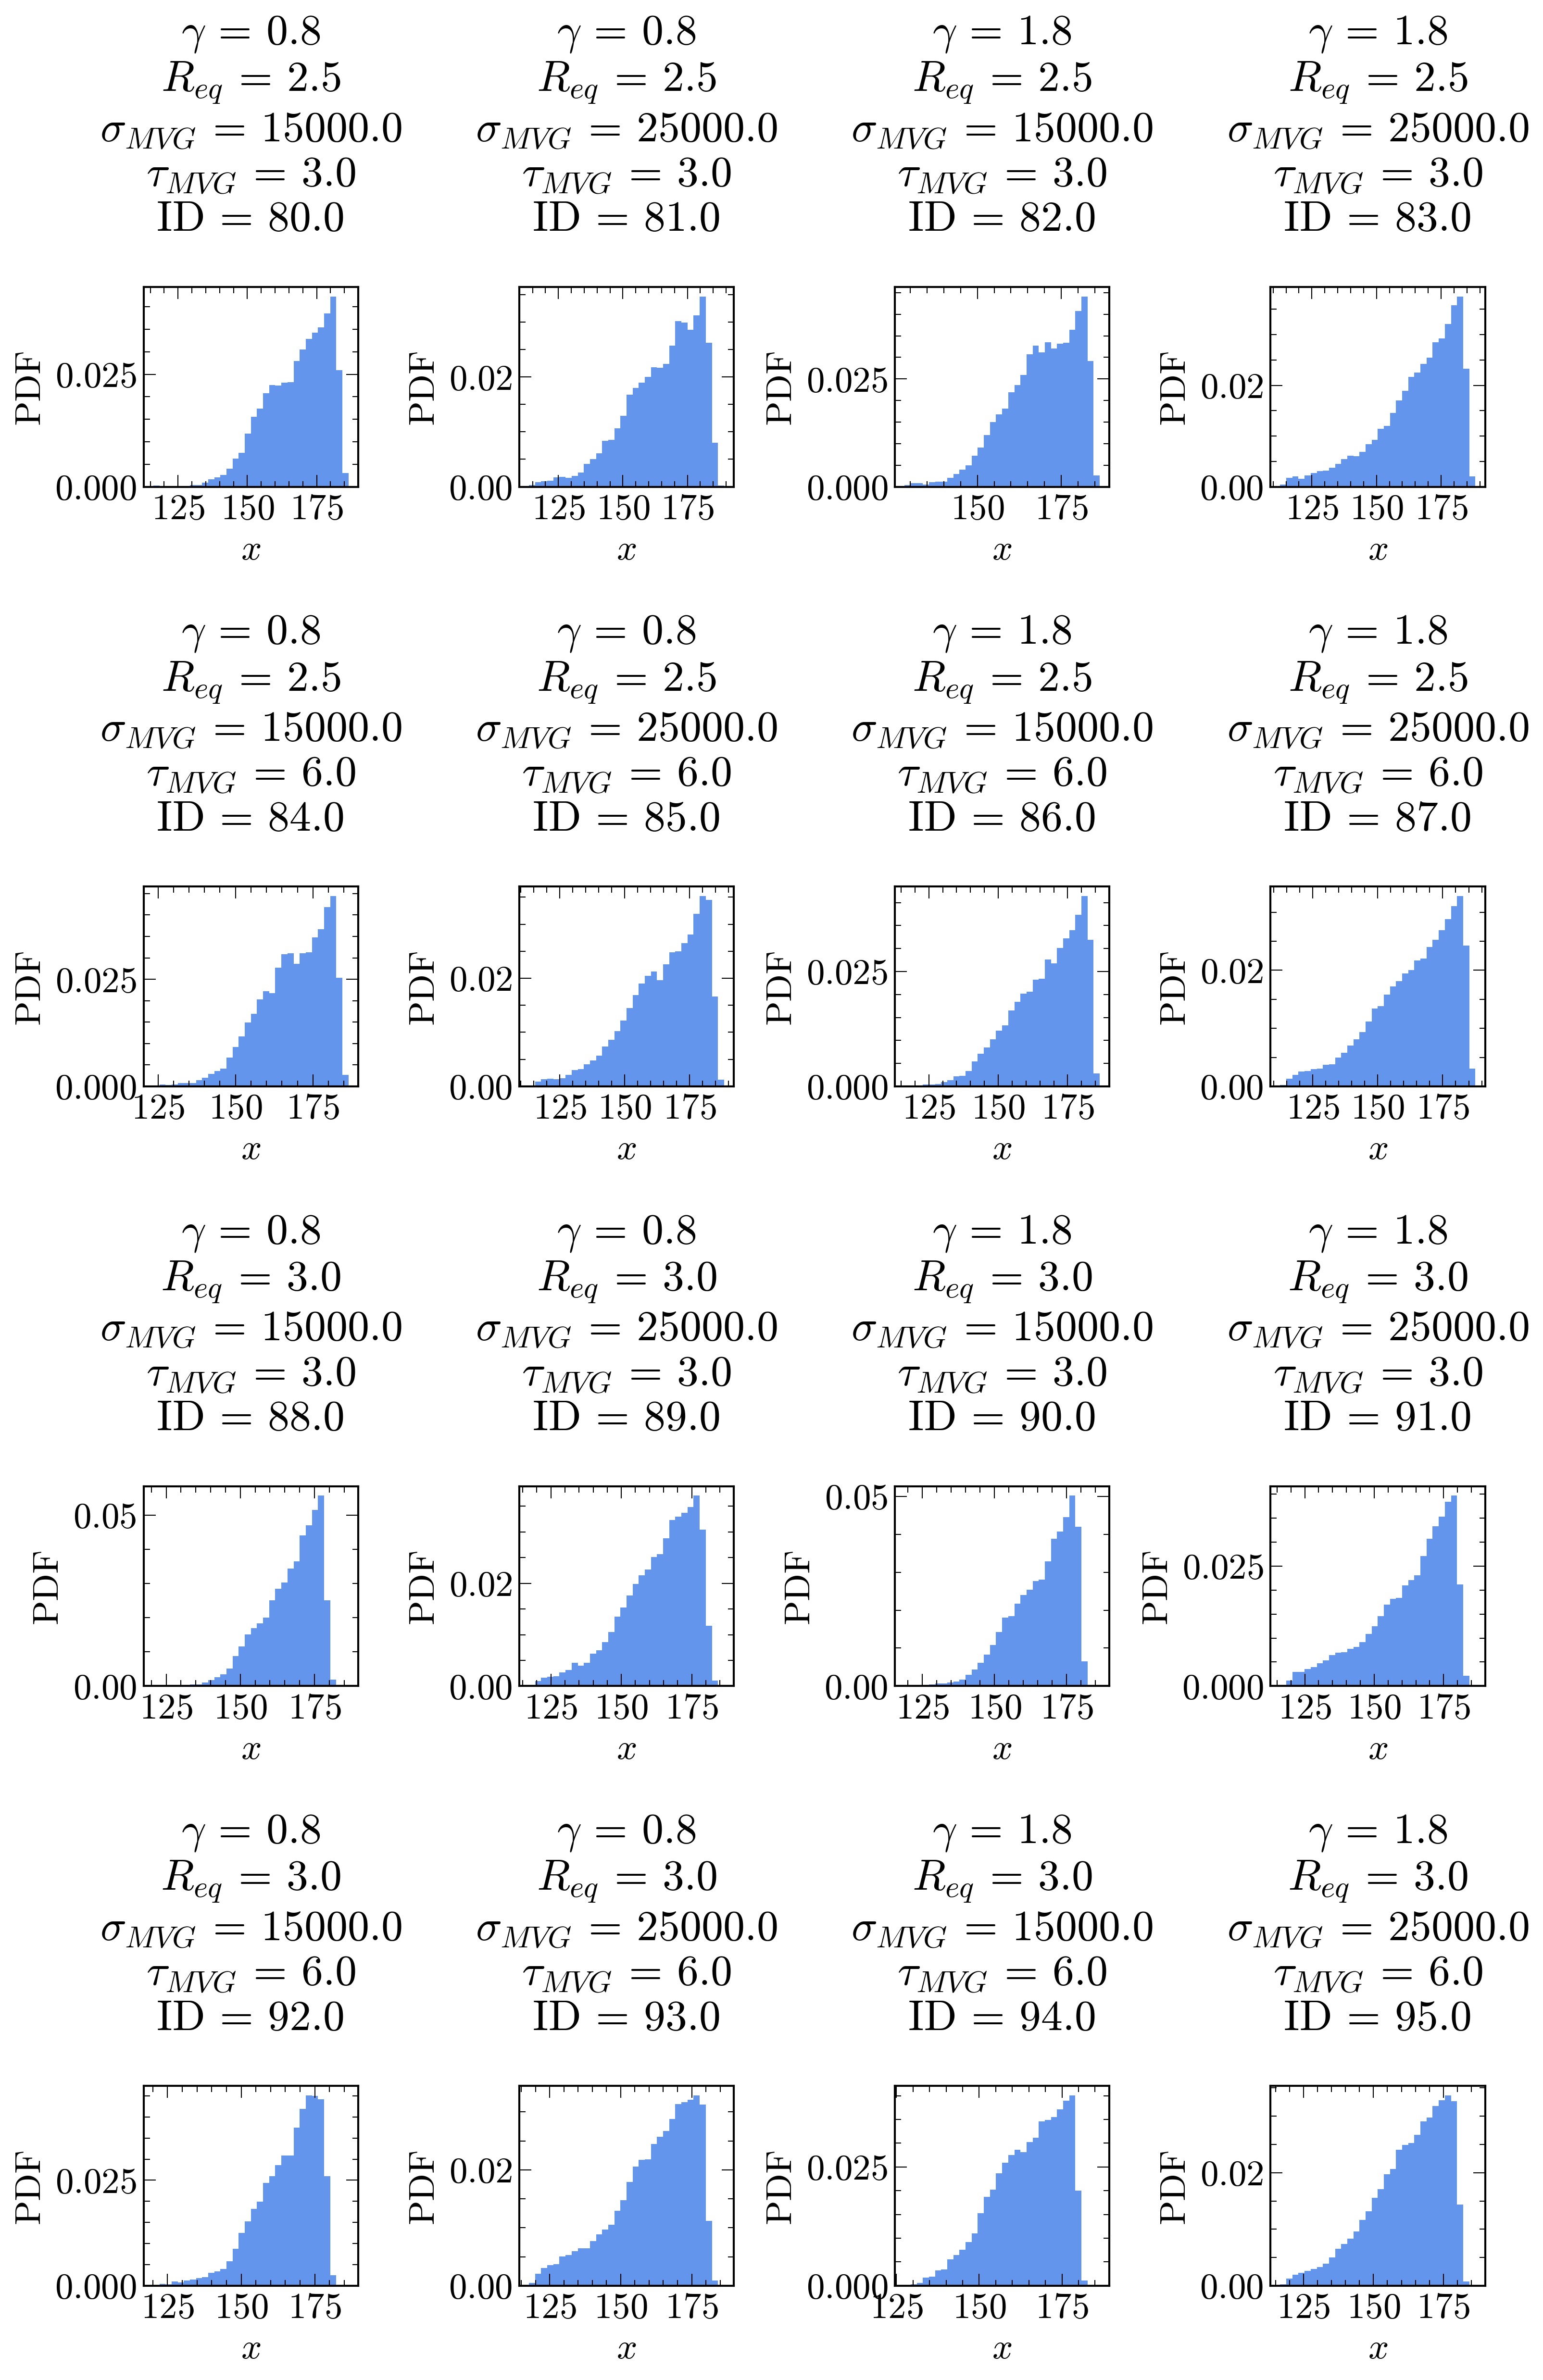

: 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


root = "debugging_asymmetry"
_format = "parquet"
files = np.asarray(glob(f"../../../../Desktop/fulltake_gid*.{_format}"))
gids = np.asarray([int(f.split("gid")[-1].split(".")[0]) for f in files])
fig, axs = plt.subplots(4, 4, figsize=(12, 18), dpi=300)
fig2, axs2 = plt.subplots(4, 4, figsize=(12, 18), dpi=300)

for k, f in enumerate(files[np.argsort(gids)][start:end]):
    if _format == "pkl":
        df_gid = pd.read_pickle(f)
    else:
        df_gid = pd.read_parquet(f)

    gid = df_gid.iloc[0].gid.astype(int)
    print(f"Grid ID = {gid}")
    df_gid.x *= 6
    df_gid.y *= 6
    nbins = 32

    df_rids_left = []
    df_rids_right = []
    for _, df in df_gid.groupby("rid"):
        if df.iloc[0].x > 25 * 6:
            df_rids_right.append(df)
        else:
            df_rids_left.append(df)

    df_gid_left = pd.concat(df_rids_left)
    df_gid_right = pd.concat(df_rids_right)

    i, j = k // 4, k % 4
    axs[i, j].set_title(_title(df_gid_left))
    axs[i, j].hist(df_gid_left.x, bins=32, density=True, color=colors[chunk])
    axs[i, j].set_xlabel(r"$x$")
    axs[i, j].set_ylabel("PDF")

    axs2[i, j].set_title(_title(df_gid_right))
    axs2[i, j].hist(df_gid_right.x, bins=32, density=True, color=colors[chunk])
    axs2[i, j].set_xlabel(r"$x$")
    axs2[i, j].set_ylabel("PDF")

fig.subplots_adjust(wspace=0.75, hspace=2)
fig2.subplots_adjust(wspace=0.75, hspace=2)

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


root = "debugging_asymmetry"
_format = "parquet"
files = np.asarray(glob(f"../_server/sim_data/{root}/fulltake_gid*.{_format}"))
gids = np.asarray([int(f.split("gid")[-1].split(".")[0]) for f in files])
fig, axs = plt.subplots(8, 4, figsize=(12, 18), dpi=300)


for k, f in enumerate(files[np.argsort(gids)][start:end]):
    if _format == "pkl":
        df_gid = pd.read_pickle(f)
    else:
        df_gid = pd.read_parquet(f)

    gid = df_gid.iloc[0].gid.astype(int)
    print(f"Grid ID = {gid}")
    print(f)
    df_gid.x *= 6
    df_gid.y *= 6
    nbins = 32

    x_inits = df_gid.iloc[np.where(df_gid["time[hr]"] == 0)[0]].x.values

    i, j = k // 4, k % 4
    if i != 0:
        i *= 2
    axs[i, j].set_title(f"Grid ID = {gid}")
    axs[i, j].hist(df_gid.x, bins=32, density=True, color=colors[chunk])
    axs[i, j].set_xlabel(r"$x$")
    axs[i, j].set_ylabel("PDF")
    axs[i + 1, j].set_title(
        f"mean = {x_inits.mean():.2f}\nleft/right = {x_inits[x_inits < 25 * 6].size / x_inits.size:.1%}",
        fontsize=12,
    )
    axs[i + 1, j].hist(x_inits, bins=32, density=True, color="grey")
    axs[i + 1, j].vlines(x_inits.mean(), 0, axs[i + 1, j].get_ylim()[1])

plt.subplots_adjust(wspace=0.75, hspace=2)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


root = "debugging_asymmetry"
_format = "parquet"
files = np.asarray(
    glob(f"../_server/sim_data/{root}/cntr_data/asym_fulltake_gid*.{_format}")
)
gids = np.asarray([int(f.split("gid")[-1].split(".")[0]) for f in files])
fig, axs = plt.subplots(8, 4, figsize=(12, 18), dpi=300)

for k, f in enumerate(files[np.argsort(gids)][start:end]):
    if _format == "pkl":
        df_gid = pd.read_pickle(f)
    else:
        df_gid = pd.read_parquet(f)

    gid = df_gid.iloc[0].gid.astype(int)
    print(
        f"Grid ID = {gid}\tN runs = {df_gid.rid.unique().size}\tN records = {df_gid.shape[0]}"
    )
    df_gid.x *= 6
    df_gid.y *= 6
    df_gid.cs_x *= 6
    df_gid.cs_y *= 6

    cm = df_gid[["x", "y"]].values
    picked_c = df_gid[["cs_x", "cs_y"]].values
    ratio = picked_c[:, 0] - cm[:, 0]
    mvg_left = df_gid["mag"].iloc[ratio < 0]
    mvg_right = df_gid["mag"].iloc[ratio > 0]
    nbins = 32

    i, j = k // 4, k % 4
    if i != 0:
        i *= 2
    axs[i, j].set_title(
        f"Grid ID = {gid}\nmean = {np.mean(ratio):.2f}\nleft/right = {np.mean(ratio < 0):.1%}",
        fontsize=14,
    )
    axs[i, j].hist(ratio, bins=32, density=True, color=colors[chunk])
    axs[i, j].set_xlabel(r"$x$")
    axs[i, j].set_ylabel("PDF")
    r = 0.4 * ratio.ptp()
    x = np.linspace(-r + 0.1, r - 0.1, 100)
    axs[i, j].plot(
        x,
        1.0 / (np.pi * r * np.sqrt(1 - (x / r) ** 2)),
        lw=2,
        color="purple",
        zorder=-1,
    )
    axs[i + 1, j].hist(mvg_left, bins=32, density=True, color="orange", alpha=0.5)
    axs[i + 1, j].hist(mvg_right, bins=32, density=True, color="blue", alpha=0.5)
    axs[i + 1, j].tick_params(axis="both", which="major", labelsize=12)
    axs[i + 1, j].tick_params(axis="both", which="minor", labelsize=8)
    axs[i + 1, j].set_xlabel("Mag strength", fontsize=12)


plt.subplots_adjust(wspace=0.75, hspace=2)
plt.show()


---

### Chase individual runs with seeds

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


gid = 161
df_gid = pd.read_parquet(
    f"../_server/sim_data/debugging_asymmetry/fulltake_gid{gid}.parquet"
)
df_gid.x *= 6
df_gid.y *= 6

plt.figure(figsize=(3, 2))
plt.hist(df_gid.x, bins=32, density=True)
plt.show()

In [ ]:
stds = [[d.x.std(), rid, d.iloc[0].seed] for rid, d in df_gid.groupby("rid")]
stds_sorted = np.array(sorted(stds, key=lambda x: x[0], reverse=True))

fig, axs = plt.subplots(4, 4, figsize=(8, 8), dpi=200)
for s, r in enumerate(stds_sorted[:16, 1]):
    # for s, r in enumerate(stds_sorted[-16:, 1]):
    df = df_gid.query("rid == @r")
    i, j = s // 4, s % 4
    axs[i, j].set_title(f"Run ID = {int(r)}", fontsize=12)
    axs[i, j].scatter(df.x, df.y, c=df.index, s=10)
    axs[i, j].set_xlabel(r"$x$")
    axs[i, j].set_ylabel(r"$y$")
    axs[i, j].tick_params(axis="both", which="major", labelsize=10)
    axs[i, j].tick_params(axis="both", which="minor", labelsize=8)
    axs[i, j].set_xlim((110, 190))
    axs[i, j].set_ylim((140, 160))

plt.subplots_adjust(hspace=0.75, wspace=0.75)
plt.show()

In [ ]:
df = df_gid.query("rid == 469")
display(df.head(5), df[:10].x)